# Linear Transformation 
We will start with the alignement of the same models for different seeds. 
- First we do not restrict the matrix.
- Second we restrict the matrix to be a rotation matrix.
- Thrid use affine transformation 
- Last but not least we are using different norms and regularization techniques to improve the results



Steps: 
- Load the same model but with different seed
- Sample different images and get latent representation 
- Create Datamatrix X and X'
- Solve the simple optimization problem (Using closed form solution as well cvxpy solver)


In [29]:
# Import relevant libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from sklearn.decomposition import PCA
import cvxpy as cp

In [12]:
# Configuration

config = {
    'path1': "/Users/mariotuci/Desktop/Google-Drive/Master/SoSe-24/Project Studies/Project/Code/latent-communication/VAE/models/MNIST_VAE_1_10.pth",
    'modelname1': 'VAE1',
    'path2': "/Users/mariotuci/Desktop/Google-Drive/Master/SoSe-24/Project Studies/Project/Code/latent-communication/VAE/models/MNIST_VAE_4_10.pth",
    'modelname2': 'VAE2',

}

# Optimization Problem in the Linear Case 
Let $x^i,y^i \in \mathbb{R^n}$ for $i = 1,...,m$ and $A \in \mathbb{R}^{n \times n}$ we are looking for the optimal A, which solves the following optimization problem 
$$ min_A \sum_{i = 1}^n ||Ax^i - y^i||^2 $$
$$ min_ a \sum_{i=1} \sum_{j =1} (A_{(j)} x^i - y^i_j)^2 $$
where we are using the euclidian norm when not otherwise stated.



## Load Model and Transformed Data for VAE
In this section we load the trained models, which we prepaired for our experimental setup

In [13]:
# get working directory
import os
# Change directory
os.chdir('/Users/mariotuci/Desktop/Google-Drive/Master/SoSe-24/Project Studies/Project/Code/latent-communication')

# Import Data 
from helper.DataLoaderMNIST import DataLoader_MNIST

# Transdormations
transformations = [transforms.ToTensor(), 
                                # Normalize between -1 and 1
                                transforms.Normalize((0.5,), (0.5,)),
                                # Flatten the Image to a vector
                                transforms.Lambda(lambda x: x.view(-1) )
                                ]
# Load the data
data_loader = DataLoader_MNIST(128, transformations)

from VAE.model_def import VAE
DEVICE = torch.device('mps')

# Initialize the models
model = VAE(in_dim=784, dims=[256, 128, 64, 32], distribution_dim=16).to(DEVICE)

# Load pretrained weights for model1
model.load_state_dict(torch.load(config['path1']))

# Initialize the model 2
model2 = VAE(in_dim=784, dims=[256, 128, 64, 32], distribution_dim=16).to(DEVICE)
# Load pretrained weights for model2
model2.load_state_dict(torch.load(config['path2']))




<All keys matched successfully>

## Sampling 
We sample images from the train set and encode those for each model. In this section we implemented two sampler.
One just samples randomly and the second samples accordingly to the classes.

In [14]:
# Simple Sampler which takes random points from the train set

def sampler(m,model1, model2): 
    images, _ = next(iter(data_loader.train_loader))
    all_images = []
    all_labels = []
    for images, labels in data_loader.train_loader:
        all_images.append(images)
        all_labels.append(labels)
    # Concatenate all the batches to form a single tensor for images and labels
    all_images = torch.cat(all_images, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
     # Sample indices from the train set
    indices = np.random.choice(all_images.shape[0], m, replace=False)

    all_images_sample = all_images[indices]
    all_labels_sample = all_labels[indices]
    

    z1 = model1.getLatenSpace(all_images_sample.to(DEVICE))
    z2 = model2.getLatenSpace(all_images_sample.to(DEVICE))

    # Detach from GPU
    z1 = z1.detach().cpu().numpy()
    z2 = z2.detach().cpu().numpy()  

    return z1, z2, all_images_sample, all_labels_sample

z1, z2, images, labels = sampler(100, model, model2)


# Samples from every class
def sampler_sufficient(m,model1,model2):
    images, _ = next(iter(data_loader.train_loader))
    all_images = []
    all_labels = []
    for images, labels in data_loader.train_loader:
        all_images.append(images)
        all_labels.append(labels)
    # Concatenate all the batches to form a single tensor for images and labels
    all_images = torch.cat(all_images, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    # Distinct labels
    labels = torch.unique(all_labels)
    # Sample size per label
    m_per_label = m // len(labels)
    # Sample from each label
    indices = []
    for label in labels:
        indices_label = np.where(all_labels == label)[0]
        indices_label = np.random.choice(indices_label, m_per_label, replace=False)
        indices.extend(indices_label)
    
    all_images_sample = all_images[indices]
    # Get latent space 
    z1 = model1.getLatenSpace(all_images_sample.to(DEVICE))
    z2 = model2.getLatenSpace(all_images_sample.to(DEVICE))

    # Detach from GPU
    z1 = z1.detach().cpu().numpy()
    z2 = z2.detach().cpu().numpy()

    return z1, z2, all_images_sample

z1_suf, z2_suf, images_suf = sampler_sufficient(100, model, model2)





 

# Calulate optimal matrix 
To ensure invertibility we using as regularization the Matrix in the Frobeniusnorm with lamda as regularization parameter. We were trying to implement the closed form soultion, but we getting weird results. It seems that we calulated the wrong closed form soultion.

In [ ]:
# Calculates the optimal matrix with abritray regularization (Frobenius normm)
def optimalMatrix(z1,z2,lamda = 0.01):
    # Get the dimensions of the latent space
    d = z1.shape[1]

    # Initalize the matrices
    M = np.zeros((d, d))
    L = np.zeros((d, d))

    # Compute the matrices
    for i in range(d):
        M = M + np.outer(z1[i], z1[i])
        L = L + np.outer(z1[i], z2[i])

    # COmpute the optimal regularized matrix
    A =  L @ np.linalg.inv(M + lamda * np.eye(d)) 

    #A = np.linalg.solve((M + lamda * np.eye(d)).T, L.T).T

    return A

lamda = 1.0

A = optimalMatrix(z1,z2, lamda= lamda )
A_suf = optimalMatrix(z1_suf,z2_suf, lamda)

print(A.shape)
print(A_suf.shape)


print(A_suf)




# Distance regarding the sample size 
In this section helpd to understand the distances between the transformed points and the not transformed points. 

In [17]:
def transformedDistances(z1, z2, A):
    # Compute the transformed distances
    distances = np.zeros(z1.shape[0])
    for i in range(z1.shape[0]):
        distances[i] = np.linalg.norm(A @ z1[i] - z2[i])

    return distances

distances = transformedDistances(z1, z2, A)
distances_suf = transformedDistances(z1_suf, z2_suf, A_suf)
print(distances.shape)
print(distances_suf.shape)

distances_non = transformedDistances(z1, z2,np.eye(32) )


# Plot the distances
print('Mean Distance:', np.mean(distances))
print('Mean Distance Sufficient:', np.mean(distances_suf))
print('Mean Distance Non:', np.mean(distances_non))



(100,)
(100,)
Mean Distance: 16.474221471331674
Mean Distance Sufficient: 16.316243541432776
Mean Distance Non: 14.34499100872785


# Alignement of Transformed Latent Vectors 
The code below uses the PCA of the second model. This is the model we transform towards

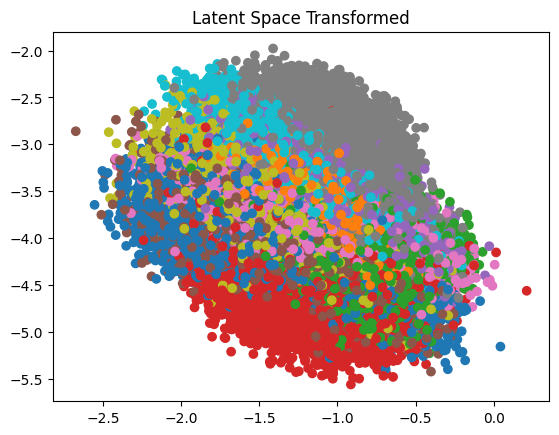

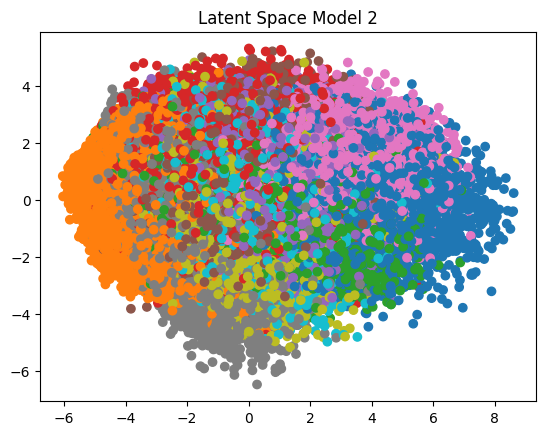

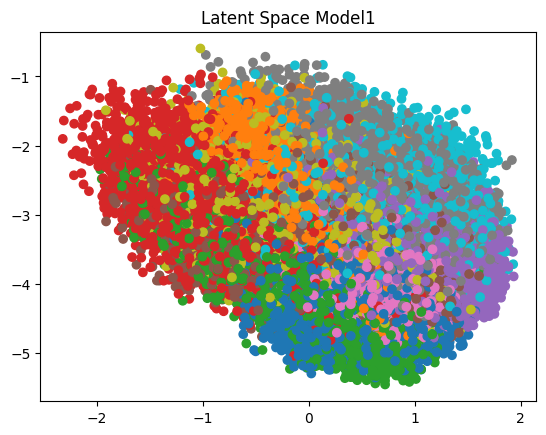

In [18]:
def pca_def(v):
    pca = PCA(n_components=2)
    pca.fit(v)
    return pca


def plotLatentTransformed(model, A, pca1, name):
    images, _ = next(iter(data_loader.train_loader))
    latent_spaces = []
    all_labels = []
    for images, labels in data_loader.train_loader:
        images = images.to(DEVICE)
        images = images.view(images.size(0), -1)
        latent_space = model.getLatenSpace(images)
        latent_space = latent_space.cpu().detach().numpy()
        latent_spaces.append(latent_space)
        all_labels.append(labels.numpy())

    # Concatenate latent space representations from all batches
    latent_space = np.concatenate(latent_spaces, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    # Transform the latent space
    latent_space_transformed = np.dot(latent_space, A.T)
    # Plot latent space via PCA
    latent_space_pca = pca1.transform(latent_space_transformed)

    # Plot the latent space

 
    plot = plt.scatter(latent_space_pca[:, 0], latent_space_pca[:, 1], c=all_labels, cmap='tab10', label=all_labels)
    plt.title('Latent Space '+ name)
    plt.show(plot)


    return  plot

I = np.eye(32)

pca1 = pca_def(z2)



plotLatentTransformed(model, A, pca1, 'Transformed')
plotLatentTransformed(model2, I, pca1, 'Model2')
plotLatentTransformed(model, I, pca1, 'Model1')

# PCA die gleich PCA die unterschiedlich 
# Sample from different classes 
# Ähnliche Werte 




# Convex Optimization Solver
## Linear Transformation with regularization
We are using the cvxpy solver which is a open source solver for convex optimization problems.

In [32]:
# Optimization Variable 
A = cp.Variable((32, 32), symmetric=True)

# Regularization Parameter
lamda = 0.01

# Loss Function
loss = cp.norm2(cp.vstack([A @ z1[i] - z2[i] for i in range(z1.shape[0])]))**2 + lamda * cp.norm(A, 'fro')**2

# Objective Function
objective = cp.Minimize(loss)

# Problem 
problem = cp.Problem(objective)

# Solve the problem
problem.solve()

# Print results
print("Optimal value: ", problem.value)
print(A.value)



Optimal value:  124.26651082695636
[[ 0.11680927  0.00476944  0.00467769 ...  0.11118277  0.0263557
   0.07645526]
 [ 0.00476944 -0.05845635  0.01206343 ...  0.14463907  0.04218122
   0.26309876]
 [ 0.00467769  0.01206343  0.         ...  0.01301722  0.00104684
   0.02588131]
 ...
 [ 0.11118277  0.14463907  0.01301722 ...  0.02628297 -0.03241985
   0.0998702 ]
 [ 0.0263557   0.04218122  0.00104684 ... -0.03241985 -0.04066884
   0.12232007]
 [ 0.07645526  0.26309876  0.02588131 ...  0.0998702   0.12232007
   0.07456781]]


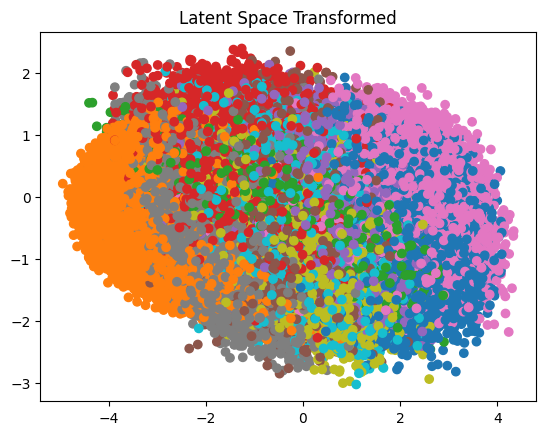

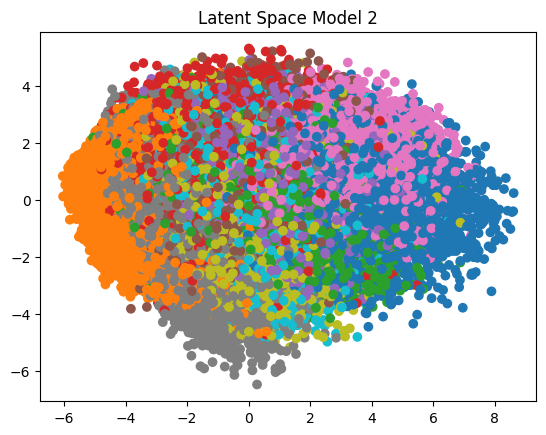

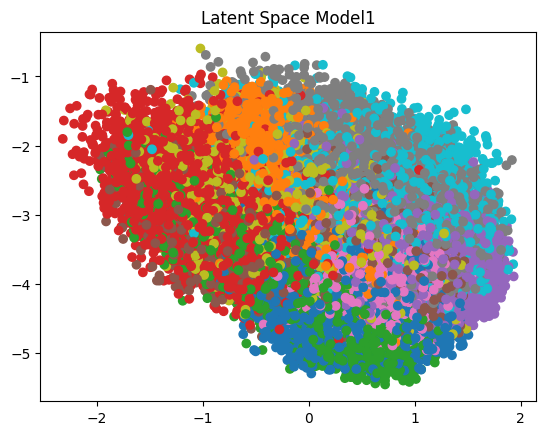

In [33]:
plotLatentTransformed(model, A.value, pca1, 'Transformed')
plotLatentTransformed(model2, I, pca1, 'Model2')
plotLatentTransformed(model, I, pca1, 'Model1')



## Affine transformation
In this section we implement the affine transformation. We are adding a offset to the problem.

In [34]:
A_aff = cp.Variable((32, 32), symmetric=True)
b_aff = cp.Variable(32)

# Loss Function
loss_aff = cp.norm2(cp.vstack([A_aff @ z1[i] + b_aff - z2[i] for i in range(z1.shape[0])]))**2 + lamda * cp.norm(A_aff, 'fro')**2

# Objective Function
objective_aff = cp.Minimize(loss_aff)

# Problem
problem_aff = cp.Problem(objective_aff)

# Solve the problem
problem_aff.solve()

# Print results
print("Optimal value: ", problem_aff.value)
print(A_aff.value)
print(b_aff.value)



Optimal value:  77.78864023018279
[[ 0.22826505 -0.0471349  -0.01850674 ...  0.12047205  0.02598397
  -0.00354881]
 [-0.0471349  -0.13786085 -0.00063592 ...  0.10257642  0.07582052
   0.16688654]
 [-0.01850674 -0.00063592  0.         ... -0.00141099 -0.00225323
  -0.00520797]
 ...
 [ 0.12047205  0.10257642 -0.00141099 ... -0.02006571 -0.09477956
   0.00898154]
 [ 0.02598397  0.07582052 -0.00225323 ... -0.09477956 -0.0050647
   0.03271931]
 [-0.00354881  0.16688654 -0.00520797 ...  0.00898154  0.03271931
  -0.11929095]]
[ 1.10844405  2.41789058  0.79438676  3.63214191 -1.23563622  3.45656974
  2.16385633  3.06033501 -0.21591699  1.27224059  0.68466033 -0.65720748
  0.03214774  3.54990681  1.54129537  2.46831838  0.25093914 -0.0703089
 -0.71803142 -0.08350367  6.26916965  0.15216921  0.79235472  1.08137068
  0.12993263  1.86864486  2.8085769   4.66240243  0.03910191  3.2495534
  0.26917755  7.56224254]


## Linear Transformation with constraints
In this section we relax the problem and consider that the matrix has to be positive semidefinite.

In [35]:
# Optimization Variable
A_psd = cp.Variable((32, 32), symmetric=True)

# Loss Function
loss_psd = cp.norm2(cp.vstack([A_psd @ z1[i] - z2[i] for i in range(z1.shape[0])]))**2 + lamda * cp.norm(A_psd, 'nuc')**2

# Objective Function
objective_psd = cp.Minimize(loss_psd)

# Constraints
constraints = [A_psd >> 0]

# Problem

problem_psd = cp.Problem(objective_psd, constraints)

# Solve the problem

problem_psd.solve()

# Print results
print("Optimal value: ", problem_psd.value)
print(A_psd.value)



Optimal value:  184.52821851175705
[[ 0.4915141   0.10288592  0.01158708 ...  0.26125761 -0.02283978
  -0.22066081]
 [ 0.10288592  0.17538981  0.06111593 ...  0.17275551  0.06273803
   0.15706933]
 [ 0.01158708  0.06111593  0.03340561 ...  0.05344754  0.0270052
  -0.00797025]
 ...
 [ 0.26125761  0.17275551  0.05344754 ...  0.29975271 -0.00748847
   0.05791563]
 [-0.02283978  0.06273803  0.0270052  ... -0.00748847  0.065875
   0.06913508]
 [-0.22066081  0.15706933 -0.00797025 ...  0.05791563  0.06913508
   1.00996679]]


## Affine Transfomrmation with positive semidefinte matrix

In [36]:
A_aff_psd = cp.Variable((32, 32), symmetric=True)
b_aff_psd = cp.Variable(32)

# Loss Function
loss_aff_psd = cp.norm2(cp.vstack([A_aff_psd @ z1[i] + b_aff_psd - z2[i] for i in range(z1.shape[0])]))**2 + lamda * cp.norm(A_aff_psd, 'nuc')**2

# Objective Function
objective_aff_psd = cp.Minimize(loss_aff_psd)

# Constraints
constraints_aff_psd = [A_aff_psd >> 0]

# Problem
problem_aff_psd = cp.Problem(objective_aff_psd, constraints_aff_psd)

# Solve the problem
problem_aff_psd.solve()

# Print results
print("Optimal value: ", problem_aff_psd.value)
print(A_aff_psd.value)
print(b_aff_psd.value)


Optimal value:  110.17789645568313
[[ 0.59941889  0.0765421  -0.04701351 ...  0.02425559 -0.05404231
  -0.30251245]
 [ 0.0765421   0.12498723  0.03882532 ...  0.09636292  0.02053233
  -0.06120212]
 [-0.04701351  0.03882532  0.05757395 ...  0.04592864 -0.01159855
  -0.00383789]
 ...
 [ 0.02425559  0.09636292  0.04592864 ...  0.30130099 -0.04737166
   0.1178245 ]
 [-0.05404231  0.02053233 -0.01159855 ... -0.04737166  0.08323094
   0.07417581]
 [-0.30251245 -0.06120212 -0.00383789 ...  0.1178245   0.07417581
   0.52727273]]
[ 1.56657648  3.06014079  1.77306828 -0.13455646 -1.22192906  0.20428856
  1.00432557  2.91485094 -0.17173382  0.56134469 -0.41411678 -2.30378345
 -0.04709375  5.38945365  1.31475394  2.52838664  0.88593357 -0.95765771
 -2.05213606  1.91663345  2.98517196 -2.38791501  0.81859007  0.7054238
 -1.48092143 -0.75633825  6.46422702  1.38683325  0.11391356  1.36268765
 -0.08466951  5.34171842]
